<a href="https://colab.research.google.com/github/YuvalSK/Perceptual-based-classfication-of-mental-health/blob/main/NN_project_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Perceptual-based classification of anxiety and depression using augmented tabular data** 

-----
## In this notebook, we'll take you through a step-by-step explanation of our project, fulfilled as part of the 'Theory of Neural Networks' course. We chose to tackle the following problem: can anxiety and depression, over binarized psychiatric groups, can be predicted using perceptual features. And if so, whether such prediction can be improved using augmented tabular data.
## We will tackle this problem in four steps:

# 1) Dataset preprocessing

## imports

In [ ]:
#sklearn for learning and preprocessing of the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_curve, auc
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler    
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

#other
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from scipy import interp
from google.colab import files
import io
import torch
import time
import random
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.test.gpu_device_name()

from google.colab import files

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
uploaded = files.upload() # upload the 'real' data colllected
df = pd.read_csv(io.BytesIO(uploaded['‏‏131_subjects.csv']))
df = df.iloc[:,1:]
df.head()

Saving ‏‏131_subjects.csv to ‏‏131_subjects.csv


,age,gender,duration,E_score,E_score2,A_score,A_score2,C_score,C_score2,N_score,...,N3,N1_conf,N3_conf,SP1_d,SP1_m,SP2_d,SP2_m,tag,health,health_long
0,20,0,8,5,3,4,3,5,5,2,...,22,0.65,0.7,1,55.0,0,45,1,None,None
1,22,0,9,7,6,5,2,6,4,2,...,30,0.10,0.2,1,60.0,1,45,1,None,None
2,21,0,5,3,5,4,5,4,4,3,...,40,0.40,0.6,0,60.0,0,20,1,None,None
3,25,1,5,7,6,5,1,6,7,6,...,25,0.70,0.6,1,90.0,1,90,0,Anxiety,Anxiety
4,25,0,5,5,5,4,5,4,4,3,...,12,0.60,0.7,1,30.0,1,45,1,None,None


## 1.1) Previous studies have shown that anxiety and depression might be two distinct bounds of a continuum (see Stavrakaki & Vargo, 1986 for review). Accordingly, in a pilot study we found that perceptual adaptaion to length of a 1-D line differs among them: an enhanced adaptation effect (AE) in anxiety vs. a reduced (near zero) adaptation effect in depression. See the plot below.

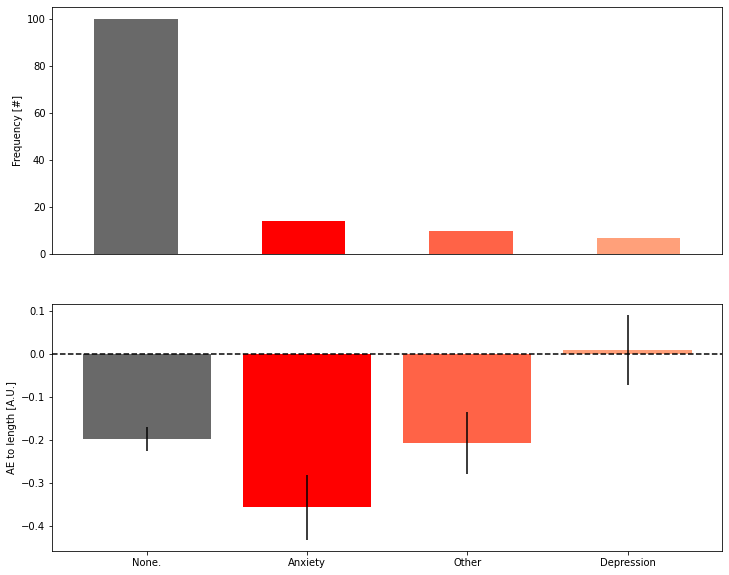

In [ ]:
from scipy import stats

plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots(2,1,figsize=(12,10))  

df['health'].value_counts().plot(ax=ax[0], kind='bar',color=['dimgray','r','tomato', 'lightsalmon'])
ax[0].set_ylabel('Frequency [#]')

df['AE_L'] = (df['L1'] - df['L3']) / 15 # calculate the AE by substracting test and retest estimates and normalized by the stimulus magnitude
new_df = pd.concat([df['AE_L'], df['health']],axis=1)
new_df['health'] = new_df["health"].replace("None", "Healthy", regex=True)
df_plot = new_df.groupby('health').agg(['mean','sem'])
df_plot.columns = df_plot.columns.map('_'.join)
df_plot = df_plot.reset_index()
df_plot = df_plot.reindex([2,0,3,1])
x_pos = np.arange(len(df_plot['health']))
labels = ['None.', 'Anxiety', 'Other', 'Depression']

ax[0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax[1].bar(x_pos, df_plot['AE_L_mean'],yerr=df_plot['AE_L_sem'], align='center',color=['dimgray','r','tomato', 'lightsalmon'])
plt.xticks(x_pos, labels)
ax[1].set_ylabel('AE to length [A.U.]')
ax[1].axhline(0,c='k', linestyle='--')

#plt.savefig('Suppl_Fig_1.png', dpi=600, bbox_inches='tight')
#files.download('Suppl_Fig_1.png')

## 1.2) Since we have little unbalanced data, we will group our data into binarized groups and add this AE as a new feature.

In [ ]:
yes, no = df['tag'].value_counts()[0], df['tag'].value_counts()[1]
print(f'Binary tags: {yes}, None: {no}')
base = yes / (yes + no)
df['health'] = LabelEncoder().fit_transform(df['health']) # label encode the tags
anx, other, dep = df['health'].value_counts()[0], df['health'].value_counts()[3], df['health'].value_counts()[1]
print(f'-out of unhealthy group, the tags we have are:\n {anx} anxiety, {other} others, {dep} depression')


Binary tags: 31, None: 100
-out of unhealthy group, the tags we have are:
 14 anxiety, 10 others, 7 depression


### One represents the group of psychiatric disorders (N = 31), and the other represents the neurotypical group ('None', N = 100).

In [ ]:
df[[c for c in df if c not in ['AE_L','tag']] + ['AE_L','tag']] 
df = df[[ col for col in df.columns if col != 'tag' ] +['tag']]
del df['health']
del df['health_long']
df.head()

,age,gender,duration,E_score,E_score2,A_score,A_score2,C_score,C_score2,N_score,...,N2,N3,N1_conf,N3_conf,SP1_d,SP1_m,SP2_d,SP2_m,AE_L,tag
0,20,0,8,5,3,4,3,5,5,2,...,50,22,0.65,0.7,1,55.0,0,45,0.000000,1
1,22,0,9,7,6,5,2,6,4,2,...,40,30,0.10,0.2,1,60.0,1,45,-0.133333,1
2,21,0,5,3,5,4,5,4,4,3,...,120,40,0.40,0.6,0,60.0,0,20,-0.266667,1
3,25,1,5,7,6,5,1,6,7,6,...,60,25,0.70,0.6,1,90.0,1,90,-0.666667,0
4,25,0,5,5,5,4,5,4,4,3,...,30,12,0.60,0.7,1,30.0,1,45,-0.333333,1


### Now we have 131 vectors with 35 features

## 2) Joint features - exploring training data to preserve cross-feature relations

Exploring test ratio of 0.3...
- Number of training examples: 91 with 70 neurotypical group and 21 psychiatric group
-Correlation analysis yielded the following features:
['N_score', 'L3_conf', 'L1_conf']


<Figure size 1440x720 with 0 Axes>

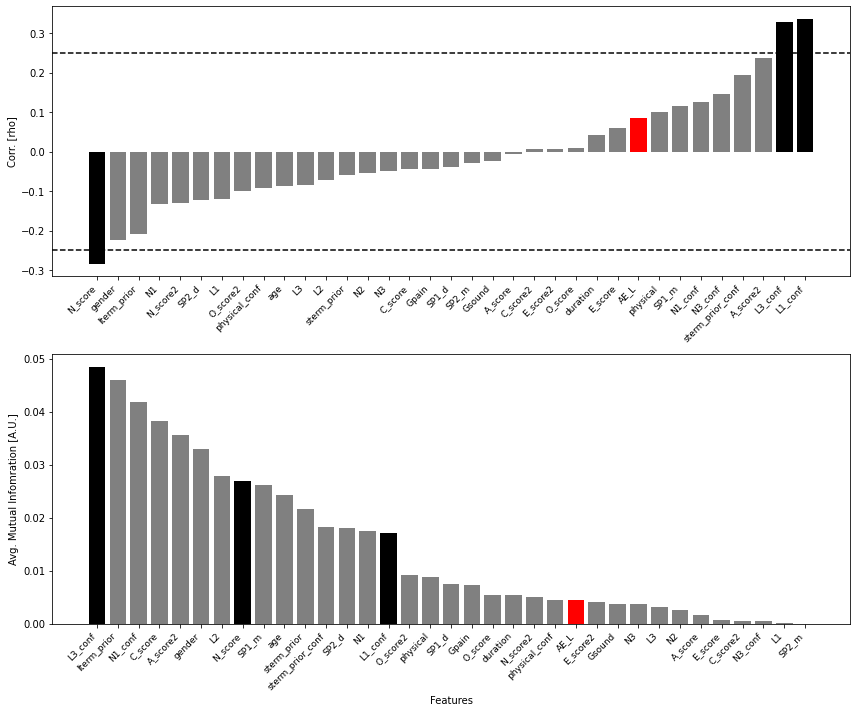

In [ ]:
x = df.iloc[:,:-1] # data
y = df.iloc[:,-1] # health tags

plt.rcParams['figure.figsize'] = [20, 10]
test_ratios = [0.3] # in the final reports, we show the results of 0.25
for t in test_ratios:
  #split train-test
  print(f'Exploring test ratio of {t}...')
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=t, random_state=0)
  print(f'- Number of training examples: {len(X_train)} with {y_train.value_counts()[1]} neurotypical group and {y_train.value_counts()[0]} psychiatric group')
  #print(f'Number of testing examples: {len(X_test)} with {y_test.value_counts()[1]} healthy')
  plt.clf()   
  fig, ax = plt.subplots(2,1,figsize=(12,10))  

  train = []
  df_train = pd.DataFrame()
  plot_corr = []
  plot_corr_sorted = []
  tags = []
  colors = []
  top_features = []
  corr = pd.DataFrame()

  #explore correlations between features and tags in training data (to avoid data leakage)  
  train = [X_train, y_train]
  df_train = pd.concat(train, axis=1)
  corr = df_train.corr(method='spearman')
  plot_corr = corr[:-1]  # get the important corr values
  plot_corr_sorted = plot_corr.sort_values('tag') # sort 
  tags = plot_corr_sorted['tag']

  x_pos = np.arange(len(plot_corr_sorted.index))

  for i in range(0,len(plot_corr_sorted)):
      colors.append('gray')
  
  #focusing on non-very weak correlations (weak<0.3)
  threshold = 0.25
  for i,c in enumerate(colors):
      if tags[i] > threshold or tags[i] < -threshold:
          colors[i] = 'k'
          top_features.append(plot_corr_sorted.index[i])
      if tags.index[i] == 'AE_L':
        colors[i] = 'red'
        #top_features.append(plot_corr_sorted.index[i])

  ax[0].bar(plot_corr_sorted.index, height = plot_corr_sorted['tag'], data = plot_corr_sorted, color=colors)
  ax[0].set_xticklabels(plot_corr_sorted.index, fontsize=9, rotation=45, ha='right')

  #ax[0].set_xticks(x_pos, plot_corr_sorted.index, rotation=45, ha='right')
  #ax[0].set_xlabel('Features')
  ax[0].set_ylabel('Corr. [rho]')
  ax[0].axhline(threshold, color='k', linestyle='--')
  ax[0].axhline(-threshold, color= 'k', linestyle='--')
  #ax[0].title(f'Correlation of health tags with features\n(test ratio: {int(t*100):.0f})')
  print(f'-Correlation analysis yielded the following features:\n{top_features}')
  
  # given the stochastic nature of MI, we run many trials and average the MI
  temp = pd.DataFrame()
  k = int(np.sqrt(len(X_train))/2)
  temp['features'] = X_train.columns
  temp['MI'] = np.zeros(len(temp['features']))

  shuffle = 30
  for i in range(shuffle):
      temp['MI'] += mutual_info_classif(X_train, y_train, n_neighbors=k)

  temp['MI'] = temp['MI'] / shuffle
  temp_sorted = temp.sort_values('MI', ascending=False) # sort 
  
  colors = []
  for i, f in enumerate(temp_sorted['features']):
      if f == 'AE_L':
        colors.append('red')
      elif f in top_features:
        colors.append('k')
      else:
          colors.append('gray')

  ax[1].bar(temp_sorted['features'], height = temp_sorted['MI'], data = temp_sorted, color=colors)
  plt.xticks(fontsize=9, rotation=45, ha='right')
  ax[1].set_xlabel('Features')
  ax[1].set_ylabel('Avg. Mutual Infomration [A.U.]')

  plt.tight_layout()
  #plt.savefig(f"Corr_{int(t*100):.0f}.png",dpi=600)
  #files.download(f"Corr_{int(t*100):.0f}.png")
  #df_train.to_csv(f"train_{int(100*t):.0f}.csv")
  #files.download(f"train_{int(100*t):.0f}.csv")


### In correlation-based analysis, we highlighted the three most correlated features (black bars in the top plot; the dotted line represents a threshold of +/- 0.25 spearman's rho). These were features of perceptual confidence ('L1_conf','L3_conf'; of test and retest length estimates) and the levels of Neuroticism ('N_score'; one of the big five personality traits). 
### In the entropy-based analysis, those three were largle in alignment with the correlation-based analysis (button plot; above the median values). The AE is represented by the red bar. Note that the highest mutual information attained was for perceptual confidence in other task('N1_conf'). 
### We found that **five main feautres** are more related to the binary health tags than others: three features of perceptual confidence ('L1_conf', 'L3_conf', 'N1_conf'), one personality trait feature ('N_score') and the perceptual adaptation effect ('AE_L'). Next, we will test their joint relations.      

[Text(0.5, 68.09375, 'Features')]

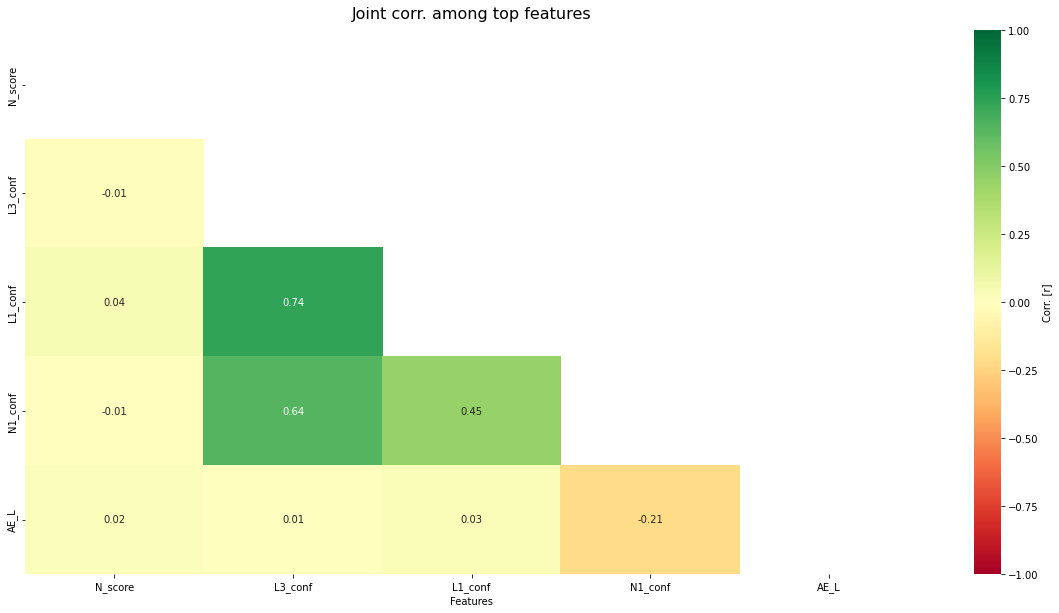

In [ ]:
plt.figure(figsize=(20, 10))
best_features = []
best_features = top_features

# manual line alert:
best_features.append('N1_conf') # may change for other test ratios beyond 0.25 and 0.3. 
best_features.append('AE_L') # due to the pilot results

corr = []
corr = df_train[best_features].corr(method='spearman')
matrix = np.triu(corr)
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdYlGn',mask=matrix, annot=True, fmt='.2f')
heatmap.set_title(f'Joint corr. among top features', fontdict={'fontsize':16}, pad=12)
heatmap.collections[0].colorbar.set_label("Corr. [r]")
heatmap.set(xlabel='Features')

#to mask below features threshold
#joint_threshold = 0.45
#corr_diff = corr.clip(joint_threshold)
#corr_diff = corr_diff.replace(joint_threshold,0)
#corr_diff[corr_diff == 0] = np.nan 
#plt.savefig('./Figs/heatmap.png', dpi=300, bbox_inches='tight') 
#from google.colab import files
#plt.savefig(f"Figure4{test_ratio*100}.png",dpi=600)
#files.download(f"Figure4{test_ratio*100}.png") 

### Three pairs pop out with strong joint relations (represented in green). To preserve their relations, we add these three new Joint Features (JF) as new features to the vectors. These three JF represent dynamics of pereceptual confidence throughout the experiment.    

In [ ]:
# relations to preserve, change per test ratio:
df_train['L3N1_conf'] = df_train['L3_conf'] - df_train['N1_conf'] # change in confidence b/w L3 task to N1 task
df_train['L31_conf'] = df_train['L3_conf'] - df_train['L1_conf'] # L3 to L1
df_train['L1N1_conf'] = df_train['L1_conf'] - df_train['N1_conf'] # L1 to N1

df_train = df_train[[c for c in df_train if c not in ['tag']] + ['tag']] # reorder
df_train.head()

#df_train.to_csv(f"train_{int(100*test_ratio)}.csv")
#files.download(f"train_{int(100*test_ratio)}.csv")

,age,gender,duration,E_score,E_score2,A_score,A_score2,C_score,C_score2,N_score,...,N3_conf,SP1_d,SP1_m,SP2_d,SP2_m,AE_L,L3N1_conf,L31_conf,L1N1_conf,tag
3,25,1,5,7,6,5,1,6,7,6,...,0.6,1,90.0,1,90,-0.666667,-0.30,-0.20,-0.1,0
43,73,1,9,6,6,2,1,7,7,2,...,0.6,1,90.0,1,10,-0.533333,0.10,0.00,0.1,1
6,32,1,5,3,3,2,2,5,3,5,...,0.5,0,25.0,1,15,-0.066667,0.00,0.00,0.0,0
126,26,0,14,3,4,5,4,1,2,5,...,0.7,1,20.0,1,10,-0.533333,0.05,0.05,0.0,1
54,20,0,10,2,1,6,4,5,5,5,...,0.6,1,15.0,1,10,0.000000,-0.10,0.00,-0.1,0


### In sum, using both correlation- and entropy-based analyses, we quntified the degree of which the features are related to health tags. We found **three pairs** of strong relations. To preserve their joint relations, we computed new JF by substracting each pair. Now we have a total of 131 vectors with 38 features. 
### These new features, represent perceptual confidence dynamics, weill be combined to generate synthetic data and predict the health tags. 

# 3) Generate synthetic data 

In [ ]:
#!pip install ctgan #install CTGAN (to generate synthetic data using GANs) and restart runtime
#!pip install table_evaluator #intall to compare real and synthetic data


In [ ]:
from ctgan import CTGANSynthesizer # make sure it runs
from table_evaluator import TableEvaluator 

In [ ]:
#uploaded = files.upload()
#df_train = pd.read_csv(io.BytesIO(uploaded[f"train_{int(100*test_ratio)}.csv"])) # upload file with test data
#df = df[['tag']+[ col for col in df.columns if col != 'tag' ]]

df_train.head() # validate the data for the analysis
data = df_train.iloc[:,1:] # note that we use 'data' despite it only contains train data
discrete_columns = ['gender', 'E_score', 'E_score2', 'A_score', 'A_score2', 
                    'C_score', 'C_score2', 'N_score', 'N_score2', 'O_score',
                    'O_score2', 'Gpain', 'Gsound', 'physical', 'sterm_prior',
                    'lterm_prior', 'SP1_d', 'SP2_d', 'tag']
im_fs = ['L3N1_conf', 'L31_conf', 'L1N1_conf'] # the JF, may vary in other test ratio


## 3.1) Generate synthetic samples using CTGAN and finetune its results by KS test

In [ ]:
t_n_bad = [] # to count how many features failed in total
t_n_imp_bad = [] # to count how many JF failed
''' 
How to finetune GANs?
based on: 'https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/'
There are few GANs tweaks we should pay attention to:
- Generator (G): If loss of the G steadily decreases, it is likely fooling the D with garbage images/data.
- Discriminator (D): The D is usually deeper. Therfore, a loss of 0.0 in the D is a failure mode.
- with Adam optimizer, lr of 0.0002 and momentum term β1 = 0.5 is recommanded
They implemented these in their paper of CTGAN: 'https://arxiv.org/pdf/1907.00503.pdf'
'''
epochs = [300, 600, 1200, 2400, 4800, 9600] #finetune number of epochs, epoch defaults in CTGAN is set to 300
samples = [len(data), 2*len(data), 400, 700, 1000] # sensativity on how many synthetic vectors to sample
glrs = [0.0002] # finetune Generator's learning rate,  defaults to 0.0002. 
dlrs = [0.0002] # finetune Discriminator's learning rate, defaults to 0.0002.

resf = pd.DataFrame(index=df_train.columns[1:])
resf['n_features'] = 0
resf['n_imp_features'] = 0

for e in epochs:
    t0 = time.time()
    ctgan = CTGANSynthesizer(epochs=e, generator_lr = glrs[0], discriminator_lr = dlrs[0], cuda=True, verbose=True) #add: 'verbose=True' for log
    ctgan.fit(data, discrete_columns)
    t1 = time.time()
    total = t1-t0
    print(f'####CTGAN (Epochs={e}, Glr={glrs[0]}, Dlr={dlrs[0]}) took: {total/60:.1f} min to train####')
    num_bad = []
    num_im_bad = []
    for s in samples:
        #print(f'##sampling {s}...')
        #path = str(f'./Figs/train_20/{e}/{s}/') # for local processing
        synthetic_data = ctgan.sample(s)
        table_evaluator = TableEvaluator(data, synthetic_data)
        #table_evaluator.visual_evaluation(save_dir=path)
        res = table_evaluator.evaluate(target_col='tag',return_outputs = True)
        k_s=res.get('Kolmogorov-Smirnov statistic') # exctract KS test pval
        features = []
        count = 0
        count_im_fs = 0
        temp = 0
        for k,v in k_s.items():
            if v.get('equality') != 'identical':
                features.append(k)
                count+=1
                resf.loc[k,'n_features'] +=1
                if k in im_fs:
                    count_im_fs+=1
                    resf.loc[k,'n_imp_features'] +=1
        num_im_bad.append(count_im_fs)
        num_bad.append(count)
        #print(f'--sampled:{s}, bad joint features / total features: {count_im_fs} / {count} [{(100*count_im_fs / count):.1f}%]')
    t_n_imp_bad.append(num_im_bad)
    t_n_bad.append(num_bad)
    print(f'####- the bad features are: {np.mean(num_im_bad):.1f} / {np.mean(num_bad):.1f}, JF / Total####')
print(f'Overall vector of results: {t_n_imp_bad} / {t_n_bad}')

#fig, ax = plt.subplots(figsize=(20,10), nrows=2, ncols=1)
#resf['n_features'] = resf['n_features'] / len(samples) / len(epochs) # avg per sample and epochs
#resf['n_imp_features'] = resf['n_imp_features'] / len(samples) / len(epochs) 
#esf_sorted = resf.sort_values('n_features', ascending=False) # sort by total features

#ax[0].bar(resf_sorted.index, height = resf_sorted['n_features'], data = resf_sorted, color='b')
#ax[1].bar(resf_sorted.index, height = resf_sorted['n_imp_features'], data = resf_sorted, color='r')

#ax[0].set_xticks(resf_sorted.index,rotation=45, ha='right')
#ax[1].set_xlabel('Features')
#ax[0].set_ylabel('Avg. falied [units]')
#ax[1].set_ylabel('Avg. important [units]')
#ax[0].set_title(f'Failed features with {epochs[0]} epochs after {len(epochs)} X times')

#plt.savefig("Figure2.png",dpi=600)
#files.download("Figure2.png") 

Streaming output truncated to the last 5000 lines.
Epoch 4604, Loss G: -0.3382,Loss D:  0.0221
Epoch 4605, Loss G: -0.1936,Loss D: -0.4647
Epoch 4606, Loss G:  0.0392,Loss D: -0.3293
Epoch 4607, Loss G: -0.1433,Loss D: -0.7031
Epoch 4608, Loss G:  0.0589,Loss D: -0.4464
Epoch 4609, Loss G: -0.4757,Loss D: -0.9400
Epoch 4610, Loss G:  0.0417,Loss D: -0.6473
Epoch 4611, Loss G:  0.3623,Loss D: -1.1523
Epoch 4612, Loss G: -0.2988,Loss D: -1.0769
Epoch 4613, Loss G: -0.0906,Loss D: -0.1711
Epoch 4614, Loss G:  0.1748,Loss D: -0.7278
Epoch 4615, Loss G:  0.1412,Loss D: -0.8027
Epoch 4616, Loss G:  0.0824,Loss D: -0.4302
Epoch 4617, Loss G:  0.0019,Loss D: -0.4343
Epoch 4618, Loss G: -0.0792,Loss D: -0.4685
Epoch 4619, Loss G:  0.1343,Loss D: -0.1312
Epoch 4620, Loss G: -0.0270,Loss D: -0.9104
Epoch 4621, Loss G:  0.1612,Loss D: -0.1851
Epoch 4622, Loss G:  0.1291,Loss D: -0.4543
Epoch 4623, Loss G: -0.2176,Loss D: -0.3967
Epoch 4624, Loss G: -0.0880,Loss D: -0.6068
Epoch 4625, Loss G: -0.13

### using the default values for learning rates, we vairied the number of epochs. Reminder: we have a total of 39 columns (38 features + 1 tags) to generate. 
### We found an overall **negative correlation** between the number of epochs and the number of features failed (more epochs = less bad features). However, using above 4800 epochs did not substantially improved the results. The following are the average results (JF / out of total features failed KS test) across samples:
*   epochs = 300 yielded: 2.6 / 15.4   
*   epochs = 600 yielded: 3.0 / 16.4
*   epochs = 1200 yielded: 2.8 / 13.6
*   epochs = 2400 yielded: 2.2 / 12.4 
*   epochs = 4800 yielded: 1.0 / 3.8
*   epochs = 9600 yielded: 0.8/ / 3.4



### using the optimal number of epochs, we tested how sensitive the results are to changes in the learning rates of the Discriminator

In [ ]:
epochs = [4800] #using the optimal number epochs
samples = [len(data), 2*len(data), 400, 700, 1000] # sensativity on how many synthetic vectors to sample
glrs = [0.0002] # defaults to 0.0002. 
dlrs = [0.001, 0.0005, 0.0001, 0.00005] # finetune Discriminator's learning rate, defaults was 0.0002.

t_n_bad = [] # to count how many features failed in total
t_n_imp_bad = [] # to count how many JF failed

for dlr in dlrs:
    t0 = time.time()
    ctgan = CTGANSynthesizer(epochs=epochs[0], generator_lr = glrs[0], discriminator_lr = dlr, cuda=True, verbose=True) #add: 'verbose=True' for log
    ctgan.fit(data, discrete_columns)
    t1 = time.time()
    total = t1-t0
    print(f'####CTGAN (Epochs={epochs[0]}, Glr={glrs[0]}, Dlr={dlrs[0]}) took: {total/60:.1f} min to train####')
    num_bad = []
    num_im_bad = []
    for s in samples:
        #print(f'##sampling {s}...')
        #path = str(f'./Figs/train_20/{e}/{s}/') # for local processing
        synthetic_data = ctgan.sample(s)
        table_evaluator = TableEvaluator(data, synthetic_data)
        #table_evaluator.visual_evaluation(save_dir=path)
        res = table_evaluator.evaluate(target_col='tag',return_outputs = True)
        k_s=res.get('Kolmogorov-Smirnov statistic') # exctract KS test pval
        features = []
        count = 0
        count_im_fs = 0
        temp = 0
        for k,v in k_s.items():
            if v.get('equality') != 'identical':
                features.append(k)
                count+=1
                if k in im_fs:
                    count_im_fs+=1
        num_im_bad.append(count_im_fs)
        num_bad.append(count)
        #print(f'--sampled:{s}, bad joint features / total features: {count_im_fs} / {count} [{(100*count_im_fs / count):.1f}%]')
    t_n_imp_bad.append(num_im_bad)
    t_n_bad.append(num_bad)
    print(f'####- the bad features are: {np.mean(num_im_bad):.1f} / {np.mean(num_bad):.1f}, JF / Total####')
print(f'Overall vector of results: {t_n_imp_bad} / {t_n_bad}')

Streaming output truncated to the last 5000 lines.
Epoch 4606, Loss G: -0.3167,Loss D: -0.4109
Epoch 4607, Loss G: -0.5547,Loss D: -0.7351
Epoch 4608, Loss G: -0.3266,Loss D: -0.6729
Epoch 4609, Loss G: -0.9063,Loss D: -0.7756
Epoch 4610, Loss G: -0.6271,Loss D: -0.5733
Epoch 4611, Loss G: -0.6804,Loss D: -0.9083
Epoch 4612, Loss G: -0.6642,Loss D: -0.7669
Epoch 4613, Loss G: -0.3956,Loss D: -0.5857
Epoch 4614, Loss G: -0.8262,Loss D: -0.8330
Epoch 4615, Loss G: -0.5056,Loss D: -0.8209
Epoch 4616, Loss G: -0.5783,Loss D: -0.7137
Epoch 4617, Loss G: -0.7545,Loss D: -0.5743
Epoch 4618, Loss G: -0.4048,Loss D: -0.7993
Epoch 4619, Loss G: -0.5230,Loss D: -0.4587
Epoch 4620, Loss G: -0.7186,Loss D: -0.6341
Epoch 4621, Loss G: -0.8406,Loss D: -0.6459
Epoch 4622, Loss G: -0.6818,Loss D: -0.7464
Epoch 4623, Loss G: -0.6911,Loss D: -0.4694
Epoch 4624, Loss G: -0.4496,Loss D: -1.0477
Epoch 4625, Loss G: -0.7197,Loss D: -0.6342
Epoch 4626, Loss G: -0.7211,Loss D: -0.6280
Epoch 4627, Loss G: -0.51

### We found that there is no gain in changing the learning rate of the D with 4800 epochs. The results were:
*   dlr = 0.001 yielded: 1.8 / 6.2     
*   dlr = 0.0005 yielded: 2.2 / 7.2
*   dlr = 0.0002 yielded: 1.0 / 3.8 (as presented above)
*   dlr = 0.0001 yielded: 1.4 / 4.6
*   dlr = 0.00005 yielded: 2 / 8.4   


## 3.2) using the optimal settings tp generate synthetic vectors:

In [ ]:
s = 400
e = 4800
glr = 0.0002
dlr = 0.0002
t0 = time.time()
ctgan = CTGANSynthesizer(epochs=e, generator_lr = glr, discriminator_lr = dlr, cuda=True) #verbose=True for log of GAN's learning process 
ctgan.fit(data, discrete_columns)
t1 = time.time()
total = t1-t0
print(f'CTGAN with {e} epochs (Glr={glr}, Dlr={dlr}) took: {total/60:.1f} min to train')

synthetic_data = ctgan.sample(s)
table_evaluator = TableEvaluator(data, synthetic_data)
res = table_evaluator.evaluate(target_col='tag',return_outputs = True)
k_s=res.get('Kolmogorov-Smirnov statistic') # exctract KS test pval
features = []
count = 0
count_im_fs = 0
for k,v in k_s.items():
  if v.get('equality') != 'identical':
    features.append(k)
    count+=1
    if k in top_features:
      print(k)
      count_im_fs+=1

#synthetic_data.to_csv(f"syn_test_{test_ratio*100}.csv")
#files.download(f"syn_test_{test_ratio*100}.csv") 

CTGAN with 4800 epochs (Glr=0.0002, Dlr=0.0002) took: 4.0 min to train


In [ ]:
print(count)
print(count_im_fs)
print(features)

4
0
['physical_conf', 'sterm_prior_conf', 'SP1_m', 'SP2_m']


### using 30% test set, only 4 features failed. Note that non of the joint or important features

# 4) Classify using real and synthetic data

### In the literature, anxiety and depression were best clasfied using RF. Here, we will compare RF with MLP using our modifitions - we'll attempt to improve MLP classfication accuracy using the augmented data.

## 4.1) Random Forest (RF)
### this approach attained an average AUC of 0.7 

In [ ]:
'''
How to implelemt RF?
RF with kfold roc - https://www.kaggle.com/kanncaa1/roc-curve-with-k-fold-cv/notebook
To improve MLP, in unbalanced labels classification we can add weights normalization: 'https://github.com/krasserm/weightnorm/tree/master/keras_2'
'''
#uploaded = files.upload()
#df = pd.read_csv(io.BytesIO(uploaded['‏‏131_subjects.csv']))
#df = df.iloc[:,1:-2]

Saving ‏‏131_subjects.csv to ‏‏131_subjects (2).csv


In [ ]:
x = df.loc[:, df.columns != 'tag']

# relations to preserve, may change per test ratio:
x['L3N1_conf'] = x['L3_conf'] - x['N1_conf'] # change in confidence b/w L3 task to N1 task
x['L31_conf'] = x['L3_conf'] - x['L1_conf'] # L3 to L1
x['L1N1_conf'] = x['L1_conf'] - x['N1_conf'] # L1 to N1

y = df.loc[:,'tag']

print(len(y))

131


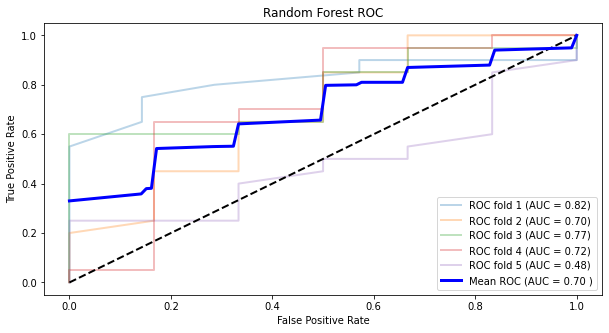

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
random_state = np.random.RandomState(0)
clf = RandomForestClassifier(random_state=random_state)
cv = StratifiedKFold(n_splits=5,shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train, test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'k')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=3, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC')
plt.legend(loc="lower right")
 
#plt.savefig(f"RF_5kfold.png",dpi=600)
#files.download(f"RF_5kfold.png")

### Using RF for classification, the average baseline classification accuracy (by AUC on test set) was 0.70.

## 4.2) MLP
### Using MLP with k-fold (k=5), we obtained the following results:
*   basic model - 70.97%
*   standardized model - 75.7%
*   small: a shallow network without hidden layer - 72.9%
*   **medium:  a network with one hidden layer - 77.4%**
*   large: a network with two hidden layer - 75.1%
### the medium model (with highest accuracy results) was further finetuned


In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
#df1 = df.values
# split into input (X) and output (Y) variables
X = x
Y = y
encoder = LabelEncoder() # for str to int
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

# baseline model
def create_baseline():
	# create model
	model = Sequential()
	model.add(Dense(38, input_dim=38, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# evaluate baseline model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
def create_smaller():
	# create model
	model = Sequential()
	model.add(Dense(19, input_dim=38, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

res = []
for i in range(3):
  estimators = []
  estimators.append(('standardize', StandardScaler()))
  estimators.append(('mlp', KerasClassifier(build_fn=create_smaller, epochs=100, batch_size=5, verbose=0)))
  pipeline = Pipeline(estimators)
  kfold = StratifiedKFold(n_splits=5, shuffle=True)
  results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
  print("-trial: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
  res.append(results.mean())
print(f'Small option - mean: {100*np.mean(res):.1f}%')

In [ ]:
# medium model
def create_medium():
  model = Sequential()
  model.add(Dense(38, input_dim=38, activation='relu'))
  model.add(Dense(19, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

res = []
for i in range(3):
  estimators = []
  estimators.append(('standardize', StandardScaler()))
  estimators.append(('mlp', KerasClassifier(build_fn=create_medium, epochs=100, batch_size=5, verbose=0)))
  pipeline = Pipeline(estimators)
  kfold = StratifiedKFold(n_splits=5, shuffle=True)
  results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
  print("-trial: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
  res.append(results.mean())
print(f'medium option - mean: {100*np.mean(res):.1f}%')

In [ ]:
# larger model
def create_larger():
  model = Sequential()
  model.add(Dense(38, input_dim=38, activation='relu'))
  model.add(Dense(19, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

	# Compile model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

res = []
for i in range(3):
  estimators = []
  estimators.append(('standardize', StandardScaler()))
  estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=100, batch_size=5, verbose=0)))
  pipeline = Pipeline(estimators)
  kfold = StratifiedKFold(n_splits=5, shuffle=True)
  results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
  print("-Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
  res.append(results.mean())
print(f'mean: {100*np.mean(res):.1f}%')

## testing with a test ratio of 30% yielded similar results, as described below
### note that for comparison, we present the results of the previous ratio (25%) in parenthesis. 

train size: (91, 38)
test size: (40, 38)
Number of training examples: 91 with 70 healthy
Number of testing examples: 40 with 30 healthy
e=300, 0.844
e=600, 0.846
e=1200, 0.831
e=2400, 0.823


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

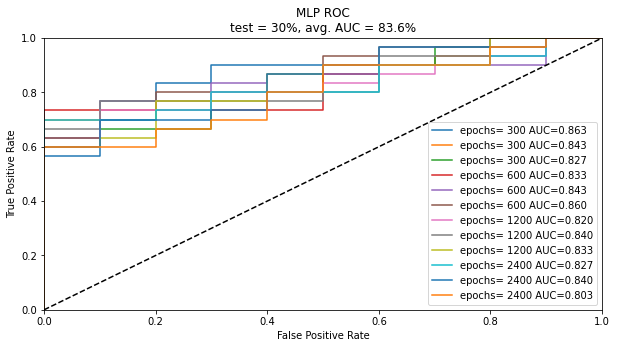

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
#finetune hyperparameters for medium network with one hidden layer
test_ratio = 0.3
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
print(f'train size: {X_train.shape}')
print(f'test size: {X_test.shape}')
print(f'Number of training examples: {len(X_train)} with {y_train.value_counts()[1]} healthy')
print(f'Number of testing examples: {len(X_test)} with {y_test.value_counts()[1]} healthy')

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

epochs = [300, 600, 1200, 2400]
t_a = []
for e in epochs:
  avg_e = []
  for i in range(3):
    model = MLPClassifier(max_iter=e,activation = 'relu',solver='adam') #hidden_layer_sizes=(17)
    model.fit(X_train, y_train)
    probs_real = model.predict_proba(X_test)
    preds_real = probs_real[:,1]
    fpr_real, tpr_real, threshold = roc_curve(y_test, preds_real)
    roc_auc_real = auc(fpr_real, tpr_real)
    lbl_str = str(f'epochs= {e} AUC={roc_auc_real:.3f}')
    avg_e.append(roc_auc_real)
    t_a.append(roc_auc_real)
    plt.plot(fpr_real, tpr_real, label = lbl_str)
  print(f'e={e}, {np.mean(avg_e):.3f}')

avg = np.mean(t_a)
plt.title(f'MLP ROC\ntest = {int(test_ratio*100)}%, avg. AUC = {100*avg:.1f}%')
plt.plot([0, 1], [0, 1],c='k', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#plt.savefig(f"MLP_finetune_Ep_{test_ratio*100}.png",dpi=600)
#files.download(f"MLP_finetune_Ep_{test_ratio*100}.png")


### The fine-tuninig process on the number of epochs yielded similar classification accuracy results. The following hyperparameters were suprior: using test ratio of 30% (25%), the best number of epochs was: 600 (1200). This attained an avg AUC of 83.6% (84.1%). 



lr=0.05, 0.793
lr=0.01, 0.829
lr=0.005, 0.798
lr=0.001, 0.809
lr=0.0005, 0.800
lr=0.0001, 0.664


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

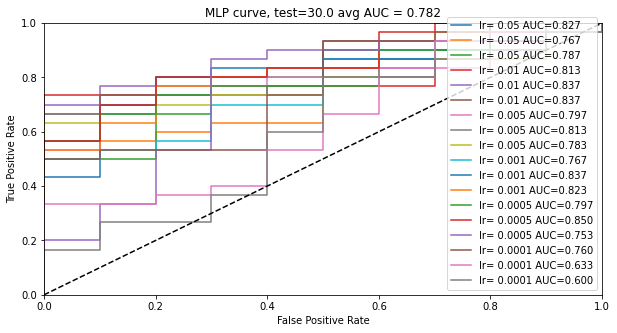

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]
lrs = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
t_a = []
for lr in lrs:
  epochs = 600
  avg_lr = []
  for i in range(3):
    model = MLPClassifier(hidden_layer_sizes=(17), max_iter=epochs,learning_rate_init = lr,activation = 'relu',solver='adam')
    model.fit(X_train, y_train)
    probs_real = model.predict_proba(X_test)
    preds_real = probs_real[:,1]
    fpr_real, tpr_real, threshold = roc_curve(y_test, preds_real)
    roc_auc_real = auc(fpr_real, tpr_real)
    lbl_str = str(f'lr= {lr} AUC={roc_auc_real:.3f}')
    t_a.append(roc_auc_real)
    avg_lr.append(roc_auc_real)
    plt.plot(fpr_real, tpr_real, label = lbl_str)
  print(f'lr={lr}, {np.mean(avg_lr):.3f}')

avg = np.mean(t_a)
plt.title(f'MLP curve, test={100*test_ratio} avg AUC = {avg:.3f}')
plt.plot([0, 1], [0, 1],c='k', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig(f"MLP_finetune_Lr_{test_ratio*100}.png",dpi=600)
files.download(f"MLP_finetune_Lr_{test_ratio*100}.png")

### The fine-tuninig process on the learning rate yielded similar classification accuracy results. The following hyperparameters were suprior: using test ratio of 30% (25%), the best lr was: 0.005 (0.05). This attained a maximum AUC of 0.85 (0.89). 

### Given these similar accuracies, we focused on the setting with the higher results of 25% test vectors. Next, we varied the number of synthetic vectors added and managed to improve this classification accuracy up to 0.867 by AUC on test set using 50% additional synthetic vectors. See the code below for details.


## 4.3) MLP on Real and Synthetic (RS) data:
### Testing how many synthetic vectors to use. We got the following average accuracy:

*   **Real + FT: 81.2%**
*   Real + 25 syn.: 72%
*   **Real + 50 syn. + FT: 85.8%** 
*   Real + 75 syn.: 75%
*   Real + 100 syn.: 79%
*   Real + 150 syn.: 72%
*   **Real + 50 syn. + FT + JF: 86.7%**








In [ ]:
#uploaded = files.upload()
#synthetic_data = pd.read_csv(io.BytesIO(uploaded['syn25.csv']))


Saving syn25.csv to syn25.csv


In [ ]:
base = df['tag'].value_counts()[1] 
prior_ratio = base/len(df['tag'])

In [ ]:
# MLP using three option of synthetic data to predict real data
base = df['tag'].value_counts()[1] 
prior_ratio = base/len(df['tag'])

test_ratio = 0.25
X_train, X_test, y_train, y_test = [], [], [], []
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
print(f'train size: {X_train.shape}')
print(f'test size: {X_test.shape}')
print(f'Number of training examples: {len(X_train)} with {y_train.value_counts()[1]} healthy')
print(f'Number of testing examples: {len(X_test)} with {y_test.value_counts()[1]} healthy')

#option 0 - real
epochs = [1200, 1200, 1200]
l_roc_auc_syn0 = []
for e in epochs:
  model = MLPClassifier(max_iter=e,learning_rate_init = 0.0005, activation = 'relu',solver='adam') #hidden_layer_sizes=(17),learning_rate_init = 0.05
  model.fit(X_train, y_train)
  probs_syn0 = model.predict_proba(X_test)
  preds_syn0 = probs_syn0[:,1]
  fpr_syn0, tpr_syn0, threshold = roc_curve(y_test, preds_syn0)
  roc_auc_syn0 = auc(fpr_syn0, tpr_syn0)
  l_roc_auc_syn0.append(roc_auc_syn0)
roc_auc_syn0 = np.mean(l_roc_auc_syn0)

print(roc_auc_syn0)

#option 1 - real + 25% syn
number_of_syn = int(len(df) * 0.25) # how many synthetic vectors to sample
sample_ratio = number_of_syn / len(synthetic_data['tag'])
synthetic_data['weights'] = np.where(synthetic_data['tag'] == 1, prior_ratio, (1-prior_ratio))
sample = synthetic_data.sample(frac=sample_ratio, random_state=111, weights='weights')

######## something is wrong here with the dimensions of the vectors
x_syn = sample.iloc[:,:-1].values
y_syn = sample.iloc[:,-1].values
syn_x = [X_train, x_syn]
X_train = np.concatenate(syn_x, axis=0)
syn_y = [y_train, y_syn]
y_train = np.concatenate(syn_y, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

l_roc_auc_syn1 = []
for e in epochs:
  print(f'-syn1, epochs={e}')
  model = MLPClassifier(hidden_layer_sizes=(19), max_iter=e,activation = 'relu',solver='adam')
  model.fit(X_train, y_train)
  probs_syn1 = model.predict_proba(X_test)
  preds_syn1 = probs_syn1[:,1]
  fpr_syn1, tpr_syn1, threshold = roc_curve(y_test, preds_syn1)
  roc_auc_syn1 = auc(fpr_syn1, tpr_syn1)
  l_roc_auc_syn1.append(roc_auc_syn1)
roc_auc_syn1 = np.mean(l_roc_auc_syn1)

#option 2 - real + 50% syn
number_of_syn = int(len(df) * 0.5) # how many synthetic vectors to sample
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
sample_ratio = number_of_syn / len(synthetic_data['tag'])
synthetic_data['weights'] = np.where(synthetic_data['tag'] == 1, prior_ratio, (1-prior_ratio))
sample = synthetic_data.sample(frac=sample_ratio, random_state=111, weights='weights')

x_syn = sample.iloc[:,1:-6].values
y_syn = sample.iloc[:,-2].values

syn_x = [X_train, x_syn]
X_train = np.concatenate(syn_x, axis=0)
syn_y = [y_train, y_syn]
y_train = np.concatenate(syn_y, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

l_roc_auc_syn2 = []
for e in epochs:
  print(f'-syn2, epochs={e}')
  model = MLPClassifier(hidden_layer_sizes=(19), max_iter=600,learning_rate_init = 0.07,activation = 'relu',solver='adam')
  model.fit(X_train, y_train)
  probs_syn2 = model.predict_proba(X_test)
  preds_syn2 = probs_syn2[:,1]
  fpr_syn2, tpr_syn2, threshold = roc_curve(y_test, preds_syn2)
  roc_auc_syn2 = auc(fpr_syn2, tpr_syn2)
  l_roc_auc_syn2.append(roc_auc_syn2)
roc_auc_syn2 = np.mean(l_roc_auc_syn2)

#option 3 - real + 75% syn
number_of_syn = int(len(df) * 0.75) # how many synthetic vectors to sample
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
sample_ratio = number_of_syn / len(synthetic_data['tag'])
synthetic_data['weights'] = np.where(synthetic_data['tag'] == 1, prior_ratio, (1-prior_ratio))
sample = synthetic_data.sample(frac=sample_ratio, random_state=111, weights='weights')

x_syn = sample.iloc[:,1:-6].values
y_syn = sample.iloc[:,-2].values
syn_x = [X_train, x_syn]
X_train = np.concatenate(syn_x, axis=0)
syn_y = [y_train, y_syn]
y_train = np.concatenate(syn_y, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

l_roc_auc_syn3 = []
for e in epochs:
  print(f'-syn3, epochs={e}')
  model = MLPClassifier(hidden_layer_sizes=(19), max_iter=e,activation = 'relu',solver='adam')
  model.fit(X_train, y_train)
  probs_syn3 = model.predict_proba(X_test)
  preds_syn3 = probs_syn3[:,1]
  fpr_syn3, tpr_syn3, threshold = roc_curve(y_test, preds_syn3)
  roc_auc_syn3 = auc(fpr_syn3, tpr_syn3)
  l_roc_auc_syn3.append(roc_auc_syn3)
roc_auc_syn3 = np.mean(l_roc_auc_syn3)

#option 4 - real + 100% syn
number_of_syn = int(len(df) * 1) # how many synthetic vectors to sample
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
sample_ratio = number_of_syn / len(synthetic_data['tag'])
synthetic_data['weights'] = np.where(synthetic_data['tag'] == 1, prior_ratio, (1-prior_ratio))
sample = synthetic_data.sample(frac=sample_ratio, random_state=111, weights='weights')

x_syn = sample.iloc[:,1:-6].values
y_syn = sample.iloc[:,-2].values
syn_x = [X_train, x_syn]
X_train = np.concatenate(syn_x, axis=0)
syn_y = [y_train, y_syn]
y_train = np.concatenate(syn_y, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

l_roc_auc_syn4 = []
for e in epochs:
  print(f'-syn4, epochs={e}')
  model = MLPClassifier(hidden_layer_sizes=(19), max_iter=e,activation = 'relu',solver='adam')
  model.fit(X_train, y_train)
  probs_syn4 = model.predict_proba(X_test)
  preds_syn4= probs_syn4[:,1]
  fpr_syn4, tpr_syn4, threshold = roc_curve(y_test, preds_syn4)
  roc_auc_syn4 = auc(fpr_syn4, tpr_syn4)
  l_roc_auc_syn4.append(roc_auc_syn4)
roc_auc_syn4 = np.mean(l_roc_auc_syn4)
#print(roc_auc_syn4)

#option 5 - real + 150% syn
number_of_syn = int(len(df) * 1.5) # how many synthetic vectors to sample
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
sample_ratio = number_of_syn / len(synthetic_data['tag'])
synthetic_data['weights'] = np.where(synthetic_data['tag'] == 1, prior_ratio, (1-prior_ratio))
sample = synthetic_data.sample(frac=sample_ratio, random_state=111, weights='weights')

x_syn = sample.iloc[:,1:-6].values
y_syn = sample.iloc[:,-2].values
syn_x = [X_train, x_syn]
X_train = np.concatenate(syn_x, axis=0)
syn_y = [y_train, y_syn]
y_train = np.concatenate(syn_y, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

l_roc_auc_syn5 = []
for e in epochs:
  print(f'-syn5, epochs={e}')
  model = MLPClassifier(hidden_layer_sizes=(19), max_iter=e,activation = 'relu',solver='adam')
  model.fit(X_train, y_train)
  probs_syn5 = model.predict_proba(X_test)
  preds_syn5= probs_syn5[:,1]
  fpr_syn5, tpr_syn5, threshold = roc_curve(y_test, preds_syn5)
  roc_auc_syn5 = auc(fpr_syn5, tpr_syn5)
  l_roc_auc_syn5.append(roc_auc_syn5)
roc_auc_syn5 = np.mean(l_roc_auc_syn5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

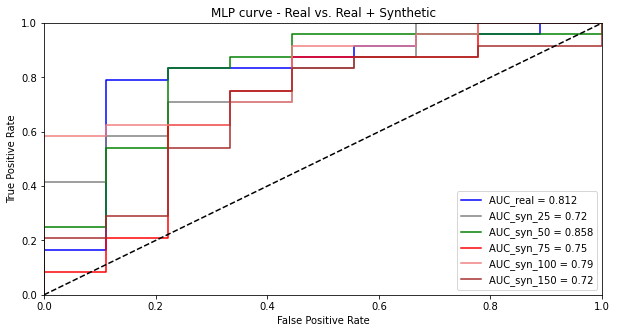

In [ ]:
plt.rcParams['figure.figsize'] = [10, 5]

plt.plot(fpr_syn0, tpr_syn0, 'b', label = 'AUC_real = %0.3f' % roc_auc_syn0) # real
plt.plot(fpr_syn1, tpr_syn1, 'gray', label = 'AUC_syn_25 = %0.2f' % roc_auc_syn1)
plt.plot(fpr_syn2, tpr_syn2, 'green', label = 'AUC_syn_50 = %0.3f' % roc_auc_syn2)
plt.plot(fpr_syn3, tpr_syn3, 'red', label = 'AUC_syn_75 = %0.2f' % roc_auc_syn3)
plt.plot(fpr_syn4, tpr_syn4, 'lightcoral', label = 'AUC_syn_100 = %0.2f' % roc_auc_syn4)
plt.plot(fpr_syn5, tpr_syn5, 'brown', label = 'AUC_syn_150 = %0.2f' % roc_auc_syn5)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],c='k', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

avg = np.mean([roc_auc_syn1, roc_auc_syn2, roc_auc_syn3, roc_auc_syn4, roc_auc_syn5])
plt.title(f'MLP curve - Real vs. Real + Synthetic')

#plt.show()
from google.colab import files
plt.savefig(f"f_{test_ratio}.png",dpi=600)
files.download(f"f_{test_ratio}.png") 

## **We achived an AUC of 0.858 using additional 50% synthetic vectors!**

In [ ]:
#option 2 - real + 50% syn
number_of_syn = int(len(df) * 0.5) # how many synthetic vectors to sample
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
sample_ratio = number_of_syn / len(synthetic_data['tag'])
synthetic_data['weights'] = np.where(synthetic_data['tag'] == 1, prior_ratio, (1-prior_ratio))
sample = synthetic_data.sample(frac=sample_ratio, random_state=111, weights='weights')

x_syn = sample.iloc[:,1:-6].values
y_syn = sample.iloc[:,-2].values

syn_x = [X_train, x_syn]
X_train = np.concatenate(syn_x, axis=0)
syn_y = [y_train, y_syn]
y_train = np.concatenate(syn_y, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

l_roc_auc_syn2 = []
epochs = [300, 600, 1200, 2400, 4800, 9600]
#lrs = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]

for e in epochs:
  avg_e = []
  for i in range(5):
    #print(f'-syn2, epochs={e}')
    model = MLPClassifier(hidden_layer_sizes=(17), max_iter=e,activation = 'relu',solver='adam')
    model.fit(X_train, y_train)
    probs_syn2 = model.predict_proba(X_test)
    preds_syn2 = probs_syn2[:,1]
    fpr_syn2, tpr_syn2, threshold = roc_curve(y_test, preds_syn2)
    roc_auc_syn2 = auc(fpr_syn2, tpr_syn2)
    l_roc_auc_syn2.append(roc_auc_syn2)
    avg_e.append(roc_auc_syn2)
  print(f'-e:{e} avg: {np.mean(avg_e):.3f}')

-e:300 avg: 0.781
-e:600 avg: 0.814
-e:1200 avg: 0.798
-e:2400 avg: 0.780
-e:4800 avg: 0.789
-e:9600 avg: 0.762


### e=600

In [ ]:
#option 2 - real + 50% syn
number_of_syn = int(len(df) * 0.5) # how many synthetic vectors to sample
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
sample_ratio = number_of_syn / len(synthetic_data['tag'])
synthetic_data['weights'] = np.where(synthetic_data['tag'] == 1, prior_ratio, (1-prior_ratio))
sample = synthetic_data.sample(frac=sample_ratio, random_state=111, weights='weights')

x_syn = sample.iloc[:,1:-6].values
y_syn = sample.iloc[:,-2].values

syn_x = [X_train, x_syn]
X_train = np.concatenate(syn_x, axis=0)
syn_y = [y_train, y_syn]
y_train = np.concatenate(syn_y, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

l_roc_auc_syn2 = []
lrs = [0.18, 0.175, 0.17, 0.08, 0.07, 0.06]

for lr in lrs:
  avg_e = []
  for i in range(10):
    #print(f'-syn2, epochs={e}')
    model = MLPClassifier(hidden_layer_sizes=(17), max_iter=600,learning_rate_init = lr, activation = 'relu',solver='adam')
    model.fit(X_train, y_train)
    probs_syn2 = model.predict_proba(X_test)
    preds_syn2 = probs_syn2[:,1]
    fpr_syn2, tpr_syn2, threshold = roc_curve(y_test, preds_syn2)
    roc_auc_syn2 = auc(fpr_syn2, tpr_syn2)
    l_roc_auc_syn2.append(roc_auc_syn2)
    avg_e.append(roc_auc_syn2)
  print(f'-lr:{lr} avg: {np.mean(avg_e):.3f}')

-lr:0.18 avg: 0.787
-lr:0.175 avg: 0.820
-lr:0.17 avg: 0.826
-lr:0.08 avg: 0.818
-lr:0.07 avg: 0.833
-lr:0.06 avg: 0.819


### lr =0.07

### Here we will test whether the JF improve the classification accuracy

In [ ]:
# order both in the same order with joint features
df['AE_L'] = (df['L1'] - df['L3']) / 15
# L3 conf with N1 and L1
df['L3N1_conf'] = df['L3_conf'] - df['N1_conf']
df['L31_conf'] = df['L3_conf'] - df['L1_conf']

# L1 conf with N1 conf
df['L1N1_conf'] = df['L1_conf'] - df['N1_conf']
df = df[[ col for col in df.columns if col != 'tag' ] + ['tag']]
#del df['health']
#del df['health_long']
df.head()

,age,gender,duration,E_score,E_score2,A_score,A_score2,C_score,C_score2,N_score,N_score2,O_score,O_score2,Gpain,Gsound,physical,physical_conf,sterm_prior,sterm_prior_conf,lterm_prior,L1,L2,L3,L1_conf,L3_conf,N1,N2,N3,N1_conf,N3_conf,SP1_d,SP1_m,SP2_d,SP2_m,AE_L,L3N1_conf,L31_conf,L1N1_conf,tag
0,20,0,8,5,3,4,3,5,5,2,3,5,4,2,2,0,0.9,3,1.0,1,13,10,13,0.60,0.6,23,50,22,0.65,0.7,1,55.0,0,45,0.000000,-0.05,0.00,-0.05,1
1,22,0,9,7,6,5,2,6,4,2,3,4,7,10,6,1,0.7,3,1.0,1,8,8,10,0.30,0.4,25,40,30,0.10,0.2,1,60.0,1,45,-0.133333,0.30,0.10,0.20,1
2,21,0,5,3,5,4,5,4,4,3,5,3,4,5,7,0,0.5,3,0.6,1,15,11,19,0.70,0.7,30,120,40,0.40,0.6,0,60.0,0,20,-0.266667,0.30,0.00,0.30,1
3,25,1,5,7,6,5,1,6,7,6,2,6,6,8,9,0,0.4,0,0.5,1,20,12,30,0.60,0.4,36,60,25,0.70,0.6,1,90.0,1,90,-0.666667,-0.30,-0.20,-0.10,0
4,25,0,5,5,5,4,5,4,4,3,5,6,5,3,8,0,0.8,0,1.0,1,10,10,15,0.75,0.7,15,30,12,0.60,0.7,1,30.0,1,45,-0.333333,0.10,-0.05,0.15,1


In [ ]:
print(f'synthetic data:{synthetic_data.shape}')
print(f'real data:{df.shape}')


synthetic data:(400, 41)
real data:(131, 39)


In [ ]:
base = df['tag'].value_counts()[1] 
prior_ratio = base/len(df['tag'])

synthetic_data['tag'].value_counts()


1    292
0    108
Name: tag, dtype: int64

In [ ]:
# MLP using joint features and adaptation
x = df.iloc[:,:-1] # data
y = df.iloc[:,-1] # health tags

test_ratio = 0.25
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
print(f'train size: {X_train.shape}')
print(f'test size: {X_test.shape}')
print(f'Number of training examples: {len(X_train)} with {y_train.value_counts()[1]} healthy')
print(f'Number of testing examples: {len(X_test)} with {y_test.value_counts()[1]} healthy')

#option 0 - real
epochs = [300, 600, 1200, 2400]
l_roc_auc_syn0 = []
for e in epochs:
  avg_e = []
  for i in range(3):
    model = MLPClassifier(hidden_layer_sizes=(19), max_iter=e,learning_rate_init = 0.05, activation = 'relu',solver='adam')
    model.fit(X_train, y_train)
    probs_syn0 = model.predict_proba(X_test)
    preds_syn0 = probs_syn0[:,1]
    fpr_syn0, tpr_syn0, threshold = roc_curve(y_test, preds_syn0)
    roc_auc_syn0 = auc(fpr_syn0, tpr_syn0)
    l_roc_auc_syn0.append(roc_auc_syn0)
    avg_e.append(roc_auc_syn0)
  print(f'-e={e}, avg={np.mean(avg_e):.3f}')
roc_auc_syn0 = np.mean(l_roc_auc_syn0)
print(roc_auc_syn0)

#option 1 - real + 50% syn
number_of_syn = int(len(df) * 0.5) # how many synthetic vectors to sample
sample_ratio = number_of_syn / len(synthetic_data['tag'])
synthetic_data['weights'] = np.where(synthetic_data['tag'] == 1, prior_ratio, (1-prior_ratio))
sample = synthetic_data.sample(frac=sample_ratio, random_state=111, weights='weights')

x_syn = sample.iloc[:,1:-2].values
y_syn = sample.iloc[:,-2].values
syn_x = [X_train, x_syn]
X_train = np.concatenate(syn_x, axis=0)
syn_y = [y_train, y_syn]
y_train = np.concatenate(syn_y, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

l_roc_auc_syn1 = []
for e in epochs:
  avg_e = []
  for i in range(3):
    model = MLPClassifier(hidden_layer_sizes=(19), max_iter=e,learning_rate_init = 0.05,activation = 'relu',solver='adam')
    model.fit(X_train, y_train)
    probs_syn1 = model.predict_proba(X_test)
    preds_syn1 = probs_syn1[:,1]
    fpr_syn1, tpr_syn1, threshold = roc_curve(y_test, preds_syn1)
    roc_auc_syn1 = auc(fpr_syn1, tpr_syn1)
    l_roc_auc_syn1.append(roc_auc_syn1)
    avg_e.append(roc_auc_syn1)
  print(f'-e={e}, avg={np.mean(avg_e):.3f}')
roc_auc_syn1 = np.mean(l_roc_auc_syn1)
print(roc_auc_syn1)

train size: (98, 38)
test size: (33, 38)
Number of training examples: 98 with 76 healthy
Number of testing examples: 33 with 24 healthy
-e=300, avg=0.667
-e=600, avg=0.792
-e=1200, avg=0.715
-e=2400, avg=0.785
0.7395833333333334
-e=300, avg=0.830
-e=600, avg=0.816
-e=1200, avg=0.843
-e=2400, avg=0.810
0.8248456790123457


### real, e=600
### syn., e=1200

In [ ]:
# MLP using joint features and adaptation
x = df.iloc[:,:-1] # data
y = df.iloc[:,-1] # health tags

test_ratio = 0.25
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=0)
#print(f'train size: {X_train.shape}')
#print(f'test size: {X_test.shape}')
#print(f'Number of training examples: {len(X_train)} with {y_train.value_counts()[1]} healthy')
print(f'Number of testing examples: {len(X_test)} with {y_test.value_counts()[1]} healthy')
retest = 3

#option 0 - real
lrs = [0.01, 0.005, 0.001]
l_roc_auc_syn0 = []
print('Real')
for lr in lrs:
  avg_e = []
  for i in range(retest):
    model = MLPClassifier(hidden_layer_sizes=(19), max_iter=600,learning_rate_init = lr, activation = 'relu',solver='adam')
    model.fit(X_train, y_train)
    probs_syn0 = model.predict_proba(X_test)
    preds_syn0 = probs_syn0[:,1]
    fpr_syn0, tpr_syn0, threshold = roc_curve(y_test, preds_syn0)
    roc_auc_syn0 = auc(fpr_syn0, tpr_syn0)
    l_roc_auc_syn0.append(roc_auc_syn0)
    avg_e.append(roc_auc_syn0)
  print(f'-lr={lr}, avg={np.mean(avg_e):.3f}')
roc_auc_syn0 = np.mean(l_roc_auc_syn0)
print(roc_auc_syn0)

#option 1 - real + 50% syn
number_of_syn = int(len(df) * 0.5) # how many synthetic vectors to sample
sample_ratio = number_of_syn / len(synthetic_data['tag'])
synthetic_data['weights'] = np.where(synthetic_data['tag'] == 1, prior_ratio, (1-prior_ratio))
sample = synthetic_data.sample(frac=sample_ratio, random_state=111, weights='weights')

x_syn = sample.iloc[:,1:-2].values
y_syn = sample.iloc[:,-2].values
syn_x = [X_train, x_syn]
X_train = np.concatenate(syn_x, axis=0)
syn_y = [y_train, y_syn]
y_train = np.concatenate(syn_y, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lrs = [0.01, 0.05, 0.005]
l_roc_auc_syn1 = []
print('Synthetic')
for lr in lrs:
  avg_e = []
  for i in range(retest):
    model = MLPClassifier(hidden_layer_sizes=(19), max_iter=1200,learning_rate_init = lr,activation = 'relu',solver='adam')
    model.fit(X_train, y_train)
    probs_syn1 = model.predict_proba(X_test)
    preds_syn1 = probs_syn1[:,1]
    fpr_syn1, tpr_syn1, threshold = roc_curve(y_test, preds_syn1)
    roc_auc_syn1 = auc(fpr_syn1, tpr_syn1)
    l_roc_auc_syn1.append(roc_auc_syn1)
    avg_e.append(roc_auc_syn1)
  print(f'-lr={lr}, avg={np.mean(avg_e):.3f}')
roc_auc_syn1 = np.mean(l_roc_auc_syn1)
print(roc_auc_syn1)

Number of testing examples: 33 with 24 healthy
Real
-lr=0.01, avg=0.677
-lr=0.005, avg=0.535
-lr=0.001, avg=0.554
0.588991769547325
Synthetic
-lr=0.01, avg=0.867
-lr=0.05, avg=0.812
-lr=0.005, avg=0.784
0.8209876543209877


## **an avg accuracy of 0.867 (using e=1200 and lr=0.01)**!


### Future work: 
1.  Normalize output weights - to improve classification given the unbalanced labels (e.g., https://github.com/krasserm/weightnorm/tree/master/keras_2). 
2.  Feature importance - add SHAP values for RF (e.g., https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)  



# Draft scripts:


Text(0.5, 1.0, 'Mutual information vs. correlation')

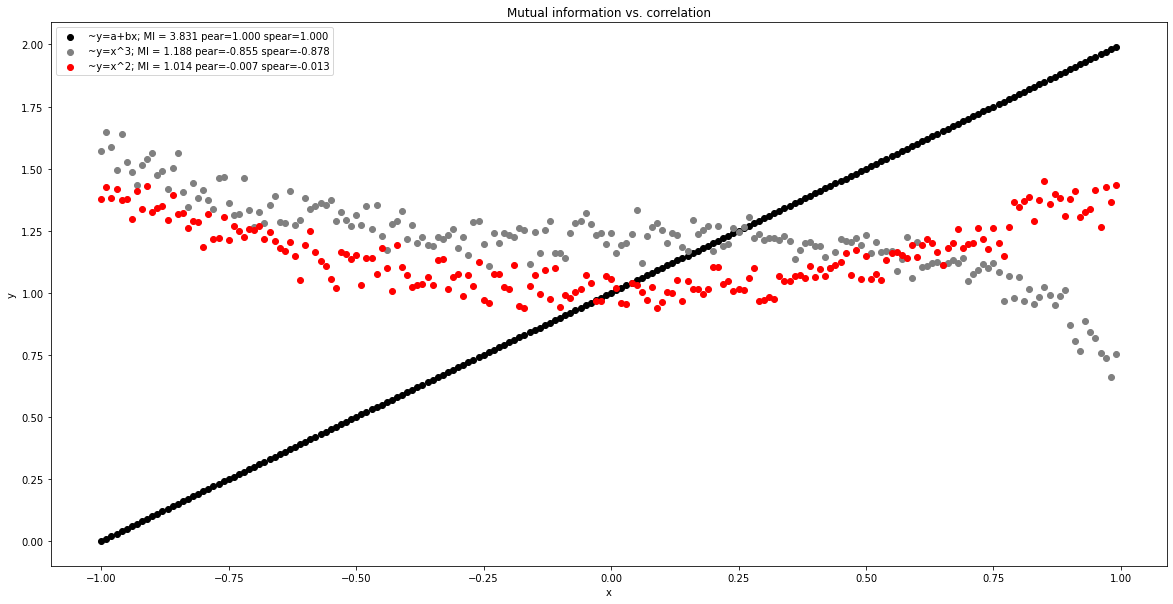

In [ ]:
'''
1) correlation vs. entorpy measures: in some non-linear relationships, both pearson and spearman fail, despite a clear visual relationship. 
'''
plt.figure(figsize=(20, 10))
ex = pd.DataFrame()
ex['x'] = np.arange(-1, 1, 0.01)
ex['y1'] = np.sqrt(1+ex['x']**2) + np.random.normal(0, 0.05, len(ex['x']))
ex['y2'] = np.sqrt(1.5-ex['x']**3) + np.random.normal(0, 0.05, len(ex['x']))
ex['y3'] = 1 + ex['x']

pear = ex.corr()

pear_y1 = pear['x']['y1']
pear_y2 = pear['x']['y2']
pear_y3 = pear['x']['y3']

spear = ex.corr(method='spearman')

spear_y1 = spear['x']['y1']
spear_y2 = spear['x']['y2']
spear_y3 = spear['x']['y3']

mi_y1 = mutual_info_regression(ex['x'].values.reshape(-1,1), ex['y1'])
mi_y2 = mutual_info_regression(ex['x'].values.reshape(-1,1), ex['y2'])
mi_y3 = mutual_info_regression(ex['x'].values.reshape(-1,1), ex['y3'])

str1 = str(f'~y=x^2; MI = {mi_y1[0]:.3f} pear={pear_y1:.3f} spear={spear_y1:.3f}')
str2 = str(f'~y=x^3; MI = {mi_y2[0]:.3f} pear={pear_y2:.3f} spear={spear_y2:.3f}')
str3 = str(f'~y=a+bx; MI = {mi_y3[0]:.3f} pear={pear_y3:.3f} spear={spear_y3:.3f}')

plt.scatter(ex['x'],ex['y3'], c='k', label = str3)
plt.scatter(ex['x'],ex['y2'], c='gray', label = str2)
plt.scatter(ex['x'],ex['y1'], c='r', label = str1)

plt.legend(loc='topright')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Mutual information vs. correlation')

#plt.savefig("Sup2.png",dpi=600)
#files.download("Sup2.png") 

In [ ]:
#for reproducable learning results:
#SEED = 1234
#random.seed(SEED)
#np.random.seed(SEED)
#torch.manual_seed(SEED)
#torch.cuda.manual_seed(SEED)
#torch.backends.cudnn.deterministic = True